# Neural Networks with NumPy and PyTorch

In this notebook we will look at how to implement various Neural Network modules using Numpy and Pytorch. We will then finally use all these modules to build a multi-layered perceptron (MLP).



In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

%matplotlib inline

# # The following code is used for hiding the warnings and make this notebook clearer.
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

## Miscellaneous code for plotting decision boundary (ignore)

In [ ]:
## Miscellaneous code to plot decision boundary (ignore) ##

def plot_decision_regions(X, y, classifier, method, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    if method == 'numpy':
        Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    elif method == 'pytorch':
        inp = torch.tensor([xx1.ravel(), xx2.ravel()], dtype=torch.float, requires_grad=False).T
        Z = np.array([]).reshape(0,1)
        for data in inp:
            out = classifier(data)
            Z = np.vstack((Z, out.data.numpy()))
    else:
        print('Not implemented')
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

## From perceptron to dense layer

We have earlier seen perceptron learning algorithm in details. A perceptron or a neuron is a mathematical function that takes in input a vector and outputs a single numerical value.

![](https://drive.google.com/uc?export=view&id=13iunc0gCEikqIJWf_LxkacCxZx2mzxpU)

The neuron is defined as follows:
$$
y = f \left( \sum_i (x_i w_i + b) \right)
$$

We will now use several of these neurons in a layer and stack several layers to create a multi-layered neural network.

![](https://drive.google.com/uc?export=view&id=1WMj9bf-TdqBobkHN80xQMmXnPzX3UQUt)

We will now create a neural network with two neurons in the hidden layer and we will show how this can model the XOR function using Numpy. However, we will write code that will allow the reader to simply modify it to allow for any number of layers and neurons in each layer, so that the reader can try simulating different scenarios. We are also going to use the hyperbolic tangent as the activity function for this network. To train the network, we will implement the back-propagation algorithm.

![](https://drive.google.com/uc?export=view&id=1Td_t6W-KvogNMLBu2zQawfNBmB161OZ7)



### Define the Neural Network class

We will now define the activation function. We will use `tanh(x)` function in this example.

In [ ]:
def tanh(x):
    return (1.0 - np.exp(-2*x))/(1.0 + np.exp(-2*x))

def tanh_derivative(x):
    return (1 + x)*(1 - x)

Next we define the `NeuralNetwork` class:

In [ ]:
class NeuralNetwork:
    def __init__(self, net_arch):
        #########
        # parameters
        # ----------
        # self:      the class object itself
        # net_arch:  consists of a list of integers, indicating
        #            the number of neurons in each layer, i.e. the network architecture
        #########
        np.random.seed(0)
        
        # Initialized the weights, making sure we also 
        # initialize the weights for the biases that we will add later
        self.activation = tanh
        self.activation_derivative = tanh_derivative
        self.layers = len(net_arch)
        self.arch = net_arch
        self.weights = []

        # Random initialization with range of weight values (-1,1)
        for layer in range(self.layers - 1):
            w = 2 * np.random.rand(net_arch[layer] + 1, net_arch[layer+1]) - 1
            self.weights.append(w)
    

    def _forward_prop(self, x):
        out = x

        for i in range(len(self.weights)-1):
            tmp_out = np.dot(out[i], self.weights[i])
            feats = self.activation(tmp_out)

            # add the bias for the next layer
            feats = np.concatenate((np.ones(1), np.array(feats)))
            out.append(feats)

        # last layer
        tmp_out = np.dot(out[-1], self.weights[-1])
        feats = self.activation(tmp_out)
        out.append(feats)
        
        return out
    

    def _back_prop(self, y, target, learning_rate):
        # calculate loss
        error = (target - y[-1])
        mse = 0.5 * (error * error)

        #calculate loss derivative
        delta_vec = [error * self.activation_derivative(y[-1])]

        # we need to begin from the back, from the next to last layer
        for i in range(self.layers-2, 0, -1):
            error = delta_vec[-1].dot(self.weights[i][1:].T)
            error = error*self.activation_derivative(y[i][1:])
            delta_vec.append(error)

        # Now we need to set the values from back to front
        delta_vec.reverse()
        
        # Finally, we adjust the weights, using the backpropagation rules
        for i in range(len(self.weights)):
            layer = y[i].reshape(1, self.arch[i]+1)
            delta = delta_vec[i].reshape(1, self.arch[i+1])
            self.weights[i] += learning_rate*layer.T.dot(delta)
    

    def fit(self, data, labels, learning_rate=0.1, epochs=100):
        #########
        # Training Routine
        #########
        # parameters
        # ----------
        # self:    the class object itself
        # data:    the set of all possible pairs of booleans True or False indicated by the integers 1 or 0
        # labels:  the result of the logical operation 'xor' on each of those input pairs
        #########

        # Add bias units to the input layer - 
        # add a "1" to the input data (the always-on bias neuron)
        ones = np.ones((1, data.shape[0]))
        Z = np.concatenate((ones.T, data), axis=1)
        
        # gradient descent iterations
        for k in range(epochs):
            # display every 10,000th epoch number
            if (k+1) % 10000 == 0:
                print('epochs: {}'.format(k+1))

            # randomly select a training data point
            sample = np.random.randint(X.shape[0])

            # We will now go ahead and set up our feed-forward propagation:
            x = [Z[sample]]
            y = self._forward_prop(x)

            # Now we do our back-propagation of the error to adjust the weights:
            target = labels[sample]
            self._back_prop(y, target, learning_rate)
    

    def predict_single_data(self, x):
        #########
        # the predict function is used to check the prediction result of
        # this neural network.
        # 
        # parameters
        # ----------
        # self:   the class object itself
        # x:      single input data
        #########
        val = np.concatenate((np.ones(1).T, np.array(x)))
        for i in range(0, len(self.weights)):
            val = self.activation(np.dot(val, self.weights[i]))
            val = np.concatenate((np.ones(1).T, np.array(val)))
        return val[1]
    

    def predict(self, X):
        #########
        # the predict function is used to check the prediction result of
        # this neural network.
        # 
        # parameters
        # ----------
        # self:   the class object itself
        # X:      the input data array
        #########
        Y = np.array([]).reshape(0, self.arch[-1])
        for x in X:
            y = np.array([[self.predict_single_data(x)]])
            Y = np.vstack((Y,y))
        return Y

In [ ]:
np.random.seed(0)

# Initialize the NeuralNetwork with
# 2 input neurons
# 2 hidden neurons
# 1 output neuron
net = NeuralNetwork([2,2,1])

# Set the input data
X = np.array([[0, 0], [0, 1],
                [1, 0], [1, 1]])

# Set the labels, the correct results for the xor operation
y = np.array([0, 1, 
                 1, 0])

# Call the fit function and train the network for a chosen number of epochs
net.fit(X, y, epochs=100000)

# Show the prediction results
print("Final prediction")
for s in X:
    print(s, net.predict_single_data(s))

epochs: 10000
epochs: 20000
epochs: 30000
epochs: 40000
epochs: 50000
epochs: 60000
epochs: 70000
epochs: 80000
epochs: 90000
epochs: 100000
Final prediction
[0 0] 2.7693903183372263e-05
[0 1] 0.995154295769496
[1 0] 0.9951532983339081
[1 1] 2.7834280538588892e-05


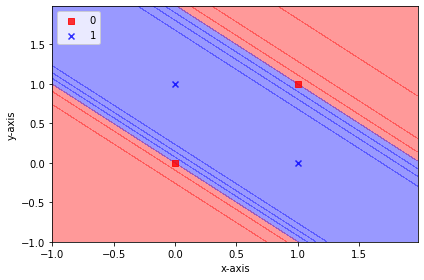

In [ ]:
np.random.seed(0)
plot_decision_regions(X, y, net, 'numpy')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### PyTorch implementation

We will now solve the same non-linear XOR problem, but this time we will use Pytorch library instead of using Numpy.

Define the input data

In [ ]:
torch.manual_seed(0)

X = torch.tensor([[0,0],[0,1], [1,0], [1,1]], dtype=torch.float, requires_grad=False)
Y = torch.tensor([0,1,1,0], dtype=torch.float, requires_grad=False)


Define the Nerual Network class `Net`

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # Initialize all the layers with learnable parameters
        self.fc1 = nn.Linear(2, 2, True) 
        self.fc2 = nn.Linear(2, 1, True)

    def forward(self, x):
        # Write the forward pass
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

model = Net()

Initialize the weights

In [ ]:
def weights_init(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # initialize the weight tensor, here we use a normal distribution
            m.weight.data.normal_(0, 1)

weights_init(model)


Define the loss function

In [ ]:
loss_func = nn.MSELoss()

Define optimizer

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

Write the training routine

In [ ]:
epochs = 5000
steps = X.size(0)
for i in range(epochs): # iterate over epoch
    for j in range(steps): # iterate over sample
        # randomly sample the inputs
        sample = np.random.randint(X.size(0))
        x_var = X[sample]
        y_var = Y[sample]
        
        optimizer.zero_grad()

        y_hat = model(x_var)
        
        loss = loss_func.forward(y_hat[0], y_var)
        loss.backward()
        
        optimizer.step()
        
    if i % 500 == 0:
        print("Epoch: {0}, Loss: {1}, ".format(i, loss.data.numpy()))

Epoch: 0, Loss: 0.22248335182666779, 
Epoch: 500, Loss: 0.3160940408706665, 
Epoch: 1000, Loss: 0.1796559989452362, 
Epoch: 1500, Loss: 0.29297852516174316, 
Epoch: 2000, Loss: 0.23936912417411804, 
Epoch: 2500, Loss: 0.3022308051586151, 
Epoch: 3000, Loss: 0.22345194220542908, 
Epoch: 3500, Loss: 0.19708336889743805, 
Epoch: 4000, Loss: 0.24158047139644623, 
Epoch: 4500, Loss: 0.03484043851494789, 


Check the output

In [ ]:
for data in X:
    output = model(data)
    print(data, np.round(output.data.numpy()))

tensor([0., 0.]) [0.]
tensor([0., 1.]) [1.]
tensor([1., 0.]) [1.]
tensor([1., 1.]) [0.]


Visualize the decision boundary

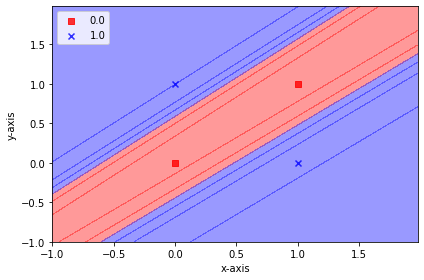

In [ ]:
np.random.seed(0)
plot_decision_regions(X.detach().numpy(), Y.detach().numpy(), model, 'pytorch')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()